In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
import tqdm
import yfinance as yf
from torch.utils.data import DataLoader
from torch.distributions import Categorical


seaborn.set_context(context="talk")
%matplotlib inline

# Finance Data

<Axes: xlabel='Date'>

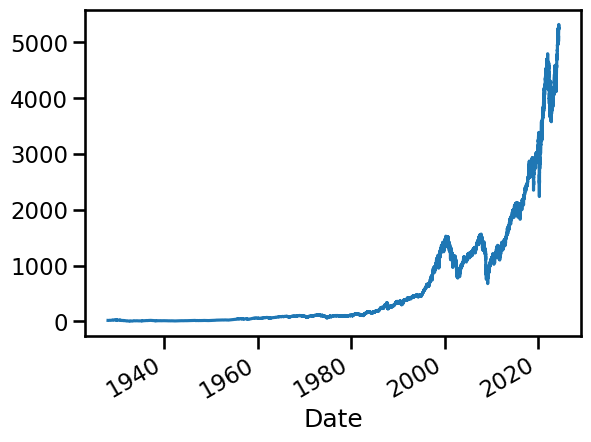

In [3]:
import yfinance as yf

spx = yf.Ticker("^SPX")
history = spx.history(period="max")
close = history["Close"]
close.plot()

In [4]:
close

Date
1927-12-30 00:00:00-05:00      17.660000
1928-01-03 00:00:00-05:00      17.760000
1928-01-04 00:00:00-05:00      17.719999
1928-01-05 00:00:00-05:00      17.549999
1928-01-06 00:00:00-05:00      17.660000
                                ...     
2024-05-24 00:00:00-04:00    5304.720215
2024-05-28 00:00:00-04:00    5306.040039
2024-05-29 00:00:00-04:00    5266.950195
2024-05-30 00:00:00-04:00    5235.479980
2024-05-31 00:00:00-04:00    5247.850098
Name: Close, Length: 24220, dtype: float64

In [5]:
len(close)

24220

In [6]:
data = close.round(2)
dates = data.index.strftime('%Y-%m-%d')
price = data.to_numpy()
d = [[price, dates] for price, dates in zip(price, dates)]
sd = d[0:10]
sd

[[17.66, '1927-12-30'],
 [17.76, '1928-01-03'],
 [17.72, '1928-01-04'],
 [17.55, '1928-01-05'],
 [17.66, '1928-01-06'],
 [17.5, '1928-01-09'],
 [17.37, '1928-01-10'],
 [17.35, '1928-01-11'],
 [17.47, '1928-01-12'],
 [17.58, '1928-01-13']]

In [7]:
class StockDataset(Dataset):
    def __init__(self, data, T=45, train_flag=True):
        self.train_flag = train_flag
        self.data_train_ratio = 0.93
        self.T = T
        self.dates = data.index.strftime('%Y-%m-%d').to_numpy()

        if train_flag:
            self.data_len = int(self.data_train_ratio * len(data))
            data_all = np.array(data)
            #print(data_all)
            self.mean = np.mean(data_all)
            self.std = np.std(data_all)
            data_all = (data_all - np.mean(data_all)) / np.std(data_all)
            self.data = data_all[ : self.data_len]

        else:
            self.data_len = int((1-self.data_train_ratio) * len(data))
            data_all = np.array(data)
            self.mean = np.mean(data_all)
            self.std = np.std(data_all)
            data_all = (data_all-np.mean(data_all))/np.std(data_all)
            #print(f"{(len(data_all))} and {len(self.dates)}")
            self.data = data_all[-self.data_len:]
            self.eval_dates = self.dates[-self.data_len:-self.T]
        #print("data len:{}".format(self.data_len))

    def __len__(self):
        return self.data_len-self.T

    def __getitem__(self, idx):
        # Returns T days worth of data and the T+1th price of data
        #print(self.data[idx:idx+self.T+1])
        data = self.data[idx:idx+self.T]
        if self.data[idx+self.T] > data[-1]:
          label = np.array([1.0, 0])
        else:
          label = np.array([0, 1.0])
        return data, self.data[idx+self.T]

In [8]:
dataset_train = StockDataset(close)
mean = dataset_train.mean
std = dataset_train.std
dataset_val = StockDataset(close, train_flag=False)

batch = 10
train_loader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch, shuffle=False)
prices, labels = next(iter(val_loader))
for price, label in zip(prices, labels):
  print(f"price: {price} and label: {label}")

price: tensor([1.8101, 1.8097, 1.8061, 1.8324, 1.8406, 1.8425, 1.8397, 1.8443, 1.8479,
        1.8506, 1.8522, 1.8447, 1.8462, 1.8408, 1.8410, 1.8510, 1.8540, 1.8631,
        1.8727, 1.8781, 1.8812, 1.8954, 1.8927, 1.8881, 1.8939, 1.8985, 1.8942,
        1.8964, 1.9008, 1.9025, 1.9044, 1.9052, 1.9181, 1.9081, 1.9122, 1.9004,
        1.9036, 1.9239, 1.9158, 1.9182, 1.9222, 1.9227, 1.9306, 1.9338, 1.9333],
       dtype=torch.float64) and label: 1.9370284574311354
price: tensor([1.8097, 1.8061, 1.8324, 1.8406, 1.8425, 1.8397, 1.8443, 1.8479, 1.8506,
        1.8522, 1.8447, 1.8462, 1.8408, 1.8410, 1.8510, 1.8540, 1.8631, 1.8727,
        1.8781, 1.8812, 1.8954, 1.8927, 1.8881, 1.8939, 1.8985, 1.8942, 1.8964,
        1.9008, 1.9025, 1.9044, 1.9052, 1.9181, 1.9081, 1.9122, 1.9004, 1.9036,
        1.9239, 1.9158, 1.9182, 1.9222, 1.9227, 1.9306, 1.9338, 1.9333, 1.9370],
       dtype=torch.float64) and label: 1.9274149547365185
price: tensor([1.8061, 1.8324, 1.8406, 1.8425, 1.8397, 1.8443, 1.847

# Model

In [ ]:
def subsequent_mask(size):
  "Mask out subsequent positions."
  attn_shape = (1, size, size)
  subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
  return torch.from_numpy(subsequent_mask) == 0

In [ ]:
def generate_square_subsequent_mask(sz):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [ ]:
a = generate_square_subsequent_mask(5)
a

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]], device='cuda:0')

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        #print(f"pe shape: {pe.shape}")
        position = torch.arange(0, max_len).unsqueeze(1)
        #print(f"position shape: {position.shape}")
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        #print(f"div_term shape: {div_term.shape}")
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        #print(f"pe shape: {pe.shape}")
        self.register_buffer('pe', pe)

    def forward(self, x):
        pos = Variable(self.pe[:, :x.size(-1)], requires_grad=False)
        #print(f"pos shape: {pos.shape}")
        x = x + pos
        return self.dropout(x)

In [ ]:
class StockTrainerEncoderModel(nn.Module):
  def __init__(self, d_model):
    super(StockTrainerEncoderModel, self).__init__()
    self.d_model = d_model
    self.positional_encoding = PositionalEncoding(d_model, 0.1)
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
    self.embedding = nn.Embedding()
    self.classification_network = nn.Sequential(
        nn.Linear(d_model, 512),
        nn.ReLU(),
        nn.Linear(512, 2),
        nn.Softmax()
    )

  def forward(self, data):
    data = data.unsqueeze(-1)
    pos_data = self.positional_encoding(data)
    encoder_out = self.transformer_encoder(pos_data)
    out = self.classification_network(encoder_out[:,-1,:])
    return out

In [ ]:
class StockTrainerTransformerModel(nn.Module):
  def __init__(self, d_model, device):
    super(StockTrainerTransformerModel, self).__init__()
    self.d_model = d_model
    self.positional_encoding = PositionalEncoding(d_model, 0.1)
    self.transformer = nn.Transformer(nhead=16, num_encoder_layers=6, batch_first=True)
    self.classification_network = nn.Sequential(
        nn.Linear(d_model, 512),
        nn.ReLU(),
        nn.Linear(512, 2),
        nn.Softmax()
    )
    self.device = device
    self.generator = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 1)
    )

  def make_tgt_data(self, data):
    tgt_dummy = torch.zeros(data.shape[0], 1, 1).to(self.device)
    #print(f"data shape: {data.shape} and tgt_dummy: {tgt_dummy.shape}")
    tgt_data = torch.cat((data, tgt_dummy), dim=1)
    pos_tgt_data = self.positional_encoding(tgt_data)
    return pos_tgt_data

  def forward(self, data):
    data = data.unsqueeze(-1)
    pos_data = self.positional_encoding(data)

    tgt = self.make_tgt_data(data)
    #print(f"tgt_data: {tgt.shape}")
    tgt_mask = generate_square_subsequent_mask(tgt.size(1)).to(self.device)
    #print(f"pos_data: {pos_data.shape}, tgt: {tgt.shape}, tgt_mask: {tgt_mask.shape}")

    transformer_out = self.transformer(pos_data, tgt, tgt_mask=tgt_mask)
    #print(f"transformer output shape: {transformer_out.shape}")
    #print(transformer_out[:,-1,:])
    #out = self.classification_network(transformer_out[:,-1,:])
    out = self.generator(transformer_out[:,-1,:])
    #print(f"out shape: {out.shape}")
    #print(f"data[:,-1]: {data[:,-1].shape}")
    return out

### Test

In [ ]:
spx = yf.Ticker("^SPX")
history = spx.history(period="max")
close = history["Close"]
dataset_train = StockDataset(close)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=False)
device = "cuda" if torch.cuda.is_available() else "cpu"

data, label = next(iter(train_loader))
print(f"data shape: {data.shape} label shape: {label.shape}")
data = data.float().to(device)
label = label.float().to(device)

model = StockTrainerTransformerModel(512, device)
model.to(device)
for p in model.parameters():
  if p.dim() > 1:
      nn.init.xavier_uniform_(p)

out = model(data)
print(out.shape)

data shape: torch.Size([32, 15]) label shape: torch.Size([32])
torch.Size([32, 1])


In [ ]:
loss_fn = nn.MSELoss()
loss = loss_fn(out, label)
print(loss)
loss.backward()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.2935, device='cuda:0', grad_fn=<MseLossBackward0>)


# Training

## Next Day Close Price Prediction

### Normalized Close Data

In [ ]:
class SP500Trainer():
  def __init__(self, epochs, run_name, normalize_data = True, batch=64, ticker="^SPX", window_size=16, one_hot=False):
    self.ticker = ticker
    self.one_hot = one_hot
    self.epochs = epochs
    self.run_name = run_name
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.normalize_data = normalize_data
    self.window_size = window_size
    self.batch = batch
    self.model = StockTrainerTransformerModel(512, self.device)
    self.model.to(self.device)
    self.loss_fn = nn.MSELoss()
    self.optim = torch.optim.Adam(self.model.parameters(), lr=2.5e-4)
    self.train_loader, self.val_loader, self.mean, self.std, self.dataset_val = self.make_data(ticker, batch, one_hot=one_hot)
    #self.AttnDecoder = AttnDecoder(512, 512, 15)

    self.writer = SummaryWriter(f"/content/drive/MyDrive/code/fintransformer/runs/{run_name}")

  def make_data(self, ticker, batch, one_hot=False):
    spx = yf.Ticker(ticker)
    history = spx.history(period="max")
    close = history["Close"]
    dataset_train = StockDataset(close)
    mean = dataset_train.mean
    std = dataset_train.std
    dataset_val = StockDataset(close, train_flag=False)
    train_loader = DataLoader(dataset_train, batch_size=batch, shuffle=True)
    val_loader = DataLoader(dataset_val, batch_size=batch, shuffle=False)
    return train_loader, val_loader, mean, std, dataset_val

  def init_params(self):
    for p in self.model.parameters():
      if p.dim() > 1:
          nn.init.xavier_uniform_(p)

  def run(self):
    ### Training ###
    predictions = None
    labels = None
    loop_range = tqdm.tqdm(range(epochs))
    self.init_params()
    for iteration in loop_range:
      train_loss = self.train()
      #raise ValueError("T Stopped")
      print("stage: train, epoch:{:5d}, loss:{}".format(iteration, train_loss))
      self.writer.add_scalar("Train/Training Loss", train_loss, iteration)
    self.writer.flush()
    self.writer.close()
    acc = self.eval_once()
    self.save_model(acc)
    return

  def train(self):
    self.model.train()
    #loader = tqdm.tqdm(self.train_loader)
    loss_epoch = 0
    for idx, (data, label) in enumerate(self.train_loader):
      """if idx == 10:
        break"""
      #print(f"data: {data}")
      data = data.float().to(device)
      label = label.float().to(device)
      preds = self.model(data)

      self.optim.zero_grad()
      #print(f"preds: {preds.shape}, label: {label.shape}")

      loss = self.loss_fn(preds, label.unsqueeze(-1))
      loss.backward()
      self.optim.step()  # 역전파 단계에서 수집된 변화도로 매개변수 조정
      loss_epoch += loss.detach().item()
    loss_epoch /= len(self.train_loader)
    return loss_epoch

  def eval_once(self):
    self.model.eval()
    #loader = tqdm.tqdm(self.val_loader)
    loss_epoch = 0
    predictions = []
    labels = []
    correct_preds = 0
    only_longs = 0
    with torch.no_grad():
      for idx, (data, label) in enumerate(self.val_loader):
        data = data.float().to(self.device)
        label = label.float().to(self.device)
        preds = self.model(data)
        loss = self.loss_fn(preds, label)
        loss_epoch += loss.detach().item()
        #print(f"preds: {preds.shape} and label: {label.shape}")
        #p = preds.detach().cpu().numpy().argmax(axis=1)
        #l = label.detach().cpu().numpy().argmax(axis=1)
        """only_long = np.zeros_like(l)
        print(f"p: {p} l: {l}")
        print(f"only_long: {only_long}")
        correct_preds += np.sum(p == l)
        only_longs += np.sum(only_long == l)"""
        predictions += ((preds.squeeze(-1) * self.std + self.mean).detach().tolist())
        #print(f"predictions: {predictions}")
        labels += ((label * self.std + self.mean).detach().tolist())
        #print(f"correct_preds: {correct_preds}")

    """accuracy = correct_preds / len(self.dataset_val)
    long_strategy = only_longs / len(self.dataset_val)
    print(f"accuracy: {accuracy} total loss: {loss_epoch}")
    print(f"only long strategy: {long_strategy}")
    if accuracy > long_strategy:
      print("Transformer Beat Always Long Strategy")
    else:
      print("Always Long Wins...Again...")"""
    #print(f"predictions: {predictions}, labels: {labels}")
    acc = self.eval_accurarcy(predictions, labels)
    return acc, predictions, labels

  def save_model(self, acc):
    PATH = f"/content/drive/MyDrive/code/fintransformer/models/{self.run_name}.pt"
    torch.save({
            'model_state_dict': self.model.state_dict(),
            'model_optimizer_state_dict': self.optim.state_dict(),
            'acc': acc}, PATH)
    print(f"Model Saved at {PATH}")

  def load_model(self, path):
    checkpoint = torch.load(path, map_location=torch.device(self.device))
    self.model.load_state_dict(checkpoint['model_state_dict'])
    self.optim.load_state_dict(checkpoint['model_optimizer_state_dict'])
    print(f"Model loaded from {path}")
    print(f"Model Accuracy: {checkpoint['acc']}")
    return


  def eval_accurarcy(self, preds, labels):
    data, label = next(iter(val_loader))
    start_price = data[0][-1].item() * self.std + self.mean
    eval_len = len(labels)
    pred_direction = []
    pred_direction.append(start_price)
    for i in range(len(preds)-1):
      if preds[i+1] > preds[i]:
        pred_direction.append(1)
      elif preds[i+1] < preds[i]:
        pred_direction.append(-1)
      else:
        pred_direction.append(0)
    label_direction = []
    label_direction.append(start_price)
    for i in range(len(labels)-1):
      if labels[i+1] > labels[i]:
        label_direction.append(1)
      elif labels[i+1] < labels[i]:
        label_direction.append(-1)
      else:
        label_direction.append(0)
    pred_direction = np.array(pred_direction)
    label_direction = np.array(label_direction)
    matches = np.sum(pred_direction == label_direction)
    acc = matches / eval_len
    print(f"model accurarcy for next day direction: {acc}")
    return acc

In [ ]:
epochs = 100
run_num = "transformer_generator_sp500_eval"

trainer = SP500Trainer(epochs, run_num, ticker="^SPX")

In [ ]:
trainer.load_model("/content/drive/MyDrive/code/fintransformer/models/transformer_generator_sp500_run1.pt")
acc, predictions, labels = trainer.eval_once()

Model loaded from /content/drive/MyDrive/code/fintransformer/models/transformer_generator_sp500_run1.pt
Model Accuracy: None


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


model accurarcy for next day direction: 0.008933889219773675


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
for p, l in zip(predictions, labels):
  print(f"p: {p}, l: {l}")

p: 372.5050048828125, l: 2500.22998046875
p: 372.5050048828125, l: 2503.8701171875
p: 372.5050048828125, l: 2506.64990234375
p: 372.5050048828125, l: 2508.240234375
p: 372.5050048828125, l: 2500.60009765625
p: 372.5050048828125, l: 2502.219970703125
p: 372.5050048828125, l: 2496.66015625
p: 372.5050048828125, l: 2496.840087890625
p: 372.5050048828125, l: 2507.0400390625
p: 372.5050048828125, l: 2510.06005859375
p: 372.5050048828125, l: 2519.360107421875
p: 372.5050048828125, l: 2529.1201171875
p: 372.5050048828125, l: 2534.580078125
p: 372.5050048828125, l: 2537.740234375
p: 372.5050048828125, l: 2552.070068359375
p: 372.5050048828125, l: 2549.330078125
p: 372.5050048828125, l: 2544.72998046875
p: 372.5050048828125, l: 2550.64013671875
p: 372.5050048828125, l: 2555.239990234375
p: 372.5050048828125, l: 2550.929931640625
p: 372.5050048828125, l: 2553.169921875
p: 372.5050048828125, l: 2557.64013671875
p: 372.5050048828125, l: 2559.3603515625
p: 372.5050048828125, l: 2561.260009765625
p:

In [ ]:
"""SP500"""
trainer.run()

  1%|          | 1/100 [00:42<1:09:44, 42.27s/it]

stage: train, epoch:    0, loss:0.28960403921982186


  2%|▏         | 2/100 [01:24<1:08:43, 42.08s/it]

stage: train, epoch:    1, loss:0.009553086044351485


  3%|▎         | 3/100 [02:05<1:07:36, 41.82s/it]

stage: train, epoch:    2, loss:0.005292379156427077


  4%|▍         | 4/100 [02:47<1:06:46, 41.74s/it]

stage: train, epoch:    3, loss:0.003967541733304229


  5%|▌         | 5/100 [03:28<1:05:55, 41.63s/it]

stage: train, epoch:    4, loss:0.003229058995533375


  6%|▌         | 6/100 [04:10<1:05:08, 41.58s/it]

stage: train, epoch:    5, loss:0.002957576719960674


  7%|▋         | 7/100 [04:51<1:04:24, 41.55s/it]

stage: train, epoch:    6, loss:0.002521143548041106


  8%|▊         | 8/100 [05:33<1:03:42, 41.54s/it]

stage: train, epoch:    7, loss:0.002508170168518766


  9%|▉         | 9/100 [06:14<1:03:00, 41.54s/it]

stage: train, epoch:    8, loss:0.0026382120466388933


 10%|█         | 10/100 [06:56<1:02:19, 41.55s/it]

stage: train, epoch:    9, loss:0.0019855329337588046


 11%|█         | 11/100 [07:37<1:01:39, 41.57s/it]

stage: train, epoch:   10, loss:0.0018935898854331092


 12%|█▏        | 12/100 [08:19<1:00:57, 41.56s/it]

stage: train, epoch:   11, loss:0.002020034204013593


 13%|█▎        | 13/100 [09:01<1:00:13, 41.54s/it]

stage: train, epoch:   12, loss:0.002244096143509854


 14%|█▍        | 14/100 [09:42<59:30, 41.51s/it]  

stage: train, epoch:   13, loss:0.0016283621774742971


 15%|█▌        | 15/100 [10:23<58:46, 41.49s/it]

stage: train, epoch:   14, loss:0.002049585580607527


 16%|█▌        | 16/100 [11:05<58:05, 41.50s/it]

stage: train, epoch:   15, loss:0.0016012567314398686


 17%|█▋        | 17/100 [11:47<57:26, 41.52s/it]

stage: train, epoch:   16, loss:0.001492701822412941


 18%|█▊        | 18/100 [12:28<56:43, 41.51s/it]

stage: train, epoch:   17, loss:0.20712964917162358


 19%|█▉        | 19/100 [13:09<56:01, 41.50s/it]

stage: train, epoch:   18, loss:0.3302392814816399


 20%|██        | 20/100 [13:51<55:20, 41.51s/it]

stage: train, epoch:   19, loss:0.32929859818382695


 21%|██        | 21/100 [14:33<54:39, 41.51s/it]

stage: train, epoch:   20, loss:0.3296811769885773


 22%|██▏       | 22/100 [15:14<53:55, 41.48s/it]

stage: train, epoch:   21, loss:0.32732660082084214


 23%|██▎       | 23/100 [15:55<53:13, 41.47s/it]

stage: train, epoch:   22, loss:0.3281414571048861


 24%|██▍       | 24/100 [16:37<52:30, 41.46s/it]

stage: train, epoch:   23, loss:0.32914256063205277


 25%|██▌       | 25/100 [17:18<51:48, 41.45s/it]

stage: train, epoch:   24, loss:0.32607506977563555


 26%|██▌       | 26/100 [18:00<51:07, 41.45s/it]

stage: train, epoch:   25, loss:0.32824799871410837


 27%|██▋       | 27/100 [18:41<50:25, 41.45s/it]

stage: train, epoch:   26, loss:0.3289313873233782


 28%|██▊       | 28/100 [19:23<49:44, 41.46s/it]

stage: train, epoch:   27, loss:0.32594573590904474


 29%|██▉       | 29/100 [20:04<49:02, 41.45s/it]

stage: train, epoch:   28, loss:0.32737283425574953


 30%|███       | 30/100 [20:45<48:18, 41.41s/it]

stage: train, epoch:   29, loss:0.3266638566062532


 31%|███       | 31/100 [21:27<47:37, 41.41s/it]

stage: train, epoch:   30, loss:0.3262456444261426


 32%|███▏      | 32/100 [22:08<46:57, 41.43s/it]

stage: train, epoch:   31, loss:0.3264299205673689


 33%|███▎      | 33/100 [22:50<46:14, 41.41s/it]

stage: train, epoch:   32, loss:0.32571234583685343


 34%|███▍      | 34/100 [23:31<45:33, 41.42s/it]

stage: train, epoch:   33, loss:0.3254255022938279


 35%|███▌      | 35/100 [24:13<44:53, 41.43s/it]

stage: train, epoch:   34, loss:0.3250086801549928


 36%|███▌      | 36/100 [24:54<44:12, 41.45s/it]

stage: train, epoch:   35, loss:0.32554890465160663


 37%|███▋      | 37/100 [25:35<43:31, 41.45s/it]

stage: train, epoch:   36, loss:0.3257301223294979


 38%|███▊      | 38/100 [26:17<42:49, 41.44s/it]

stage: train, epoch:   37, loss:0.32564228819683194


 39%|███▉      | 39/100 [26:58<42:09, 41.47s/it]

stage: train, epoch:   38, loss:0.3252598561600528


 40%|████      | 40/100 [27:40<41:27, 41.45s/it]

stage: train, epoch:   39, loss:0.32564442994242365


 41%|████      | 41/100 [28:21<40:45, 41.45s/it]

stage: train, epoch:   40, loss:0.32533932955596934


 42%|████▏     | 42/100 [29:03<40:04, 41.45s/it]

stage: train, epoch:   41, loss:0.3251467358574949


 43%|████▎     | 43/100 [29:44<39:21, 41.43s/it]

stage: train, epoch:   42, loss:0.3255181343040683


 44%|████▍     | 44/100 [30:26<38:42, 41.47s/it]

stage: train, epoch:   43, loss:0.32596787746826356


 45%|████▌     | 45/100 [31:07<37:59, 41.45s/it]

stage: train, epoch:   44, loss:0.3253872008909556


 46%|████▌     | 46/100 [31:48<37:18, 41.45s/it]

stage: train, epoch:   45, loss:0.3252940555103123


 47%|████▋     | 47/100 [32:30<36:36, 41.44s/it]

stage: train, epoch:   46, loss:0.3253211251629347


 48%|████▊     | 48/100 [33:11<35:54, 41.43s/it]

stage: train, epoch:   47, loss:0.32488042365928943


 49%|████▉     | 49/100 [33:53<35:12, 41.43s/it]

stage: train, epoch:   48, loss:0.3254572966728698


 50%|█████     | 50/100 [34:34<34:31, 41.44s/it]

stage: train, epoch:   49, loss:0.325229268648069


 51%|█████     | 51/100 [35:16<33:50, 41.44s/it]

stage: train, epoch:   50, loss:0.3244920102879405


 52%|█████▏    | 52/100 [35:57<33:08, 41.43s/it]

stage: train, epoch:   51, loss:0.32465831317346205


 53%|█████▎    | 53/100 [36:38<32:26, 41.42s/it]

stage: train, epoch:   52, loss:0.3251489662480625


 54%|█████▍    | 54/100 [37:20<31:44, 41.41s/it]

stage: train, epoch:   53, loss:0.3251168956895443


 55%|█████▌    | 55/100 [38:01<31:02, 41.38s/it]

stage: train, epoch:   54, loss:0.3249196439812129


 56%|█████▌    | 56/100 [38:42<30:20, 41.36s/it]

stage: train, epoch:   55, loss:0.32552922157232056


 57%|█████▋    | 57/100 [39:24<29:37, 41.35s/it]

stage: train, epoch:   56, loss:0.3251055222089318


 58%|█████▊    | 58/100 [40:05<28:56, 41.34s/it]

stage: train, epoch:   57, loss:0.32455689434639434


 59%|█████▉    | 59/100 [40:46<28:14, 41.34s/it]

stage: train, epoch:   58, loss:0.3246184800836173


 60%|██████    | 60/100 [41:28<27:34, 41.36s/it]

stage: train, epoch:   59, loss:0.3245689056983048


 61%|██████    | 61/100 [42:09<26:52, 41.36s/it]

stage: train, epoch:   60, loss:0.3243779392320324


 62%|██████▏   | 62/100 [42:51<26:11, 41.37s/it]

stage: train, epoch:   61, loss:0.32455450876361946


 63%|██████▎   | 63/100 [43:32<25:30, 41.37s/it]

stage: train, epoch:   62, loss:0.3242956999350678


 64%|██████▍   | 64/100 [44:13<24:49, 41.36s/it]

stage: train, epoch:   63, loss:0.32459490394897084


 65%|██████▌   | 65/100 [44:55<24:07, 41.35s/it]

stage: train, epoch:   64, loss:0.32410202391276305


 66%|██████▌   | 66/100 [45:36<23:26, 41.37s/it]

stage: train, epoch:   65, loss:0.3245183911428533


 67%|██████▋   | 67/100 [46:17<22:45, 41.37s/it]

stage: train, epoch:   66, loss:0.3245350703681735


 68%|██████▊   | 68/100 [46:59<22:03, 41.36s/it]

stage: train, epoch:   67, loss:0.32430439357730473


 69%|██████▉   | 69/100 [47:40<21:22, 41.37s/it]

stage: train, epoch:   68, loss:0.32438767815686087


 70%|███████   | 70/100 [48:22<20:41, 41.39s/it]

stage: train, epoch:   69, loss:0.3243151768957349


 71%|███████   | 71/100 [49:03<20:00, 41.40s/it]

stage: train, epoch:   70, loss:0.3244172418490052


 72%|███████▏  | 72/100 [49:44<19:19, 41.40s/it]

stage: train, epoch:   71, loss:0.3243785958991132


 73%|███████▎  | 73/100 [50:26<18:37, 41.40s/it]

stage: train, epoch:   72, loss:0.3241746016693386


 74%|███████▍  | 74/100 [51:07<17:56, 41.40s/it]

stage: train, epoch:   73, loss:0.324901026673615


 75%|███████▌  | 75/100 [51:49<17:14, 41.39s/it]

stage: train, epoch:   74, loss:0.3246331059966575


 76%|███████▌  | 76/100 [52:30<16:32, 41.37s/it]

stage: train, epoch:   75, loss:0.32447502042420884


 77%|███████▋  | 77/100 [53:11<15:52, 41.39s/it]

stage: train, epoch:   76, loss:0.32421566131101415


 78%|███████▊  | 78/100 [53:53<15:10, 41.37s/it]

stage: train, epoch:   77, loss:0.323961003260179


 79%|███████▉  | 79/100 [54:34<14:28, 41.35s/it]

stage: train, epoch:   78, loss:0.3242124588736756


 80%|████████  | 80/100 [55:15<13:47, 41.35s/it]

stage: train, epoch:   79, loss:0.32399415758184413


 81%|████████  | 81/100 [55:57<13:06, 41.38s/it]

stage: train, epoch:   80, loss:0.3241539501415735


 82%|████████▏ | 82/100 [56:38<12:25, 41.41s/it]

stage: train, epoch:   81, loss:0.3243670549921014


 83%|████████▎ | 83/100 [57:20<11:44, 41.43s/it]

stage: train, epoch:   82, loss:0.32418198498304596


 84%|████████▍ | 84/100 [58:01<11:02, 41.42s/it]

stage: train, epoch:   83, loss:0.32428205220706086


 85%|████████▌ | 85/100 [58:43<10:21, 41.41s/it]

stage: train, epoch:   84, loss:0.3243680698373778


 86%|████████▌ | 86/100 [59:24<09:39, 41.39s/it]

stage: train, epoch:   85, loss:0.324235200881958


 87%|████████▋ | 87/100 [1:00:05<08:57, 41.36s/it]

stage: train, epoch:   86, loss:0.3239763571288098


 88%|████████▊ | 88/100 [1:00:46<08:15, 41.33s/it]

stage: train, epoch:   87, loss:0.3242578365924684


 89%|████████▉ | 89/100 [1:01:28<07:34, 41.32s/it]

stage: train, epoch:   88, loss:0.32376585905016825


 90%|█████████ | 90/100 [1:02:09<06:53, 41.31s/it]

stage: train, epoch:   89, loss:0.32375148916617036


 91%|█████████ | 91/100 [1:02:50<06:11, 41.30s/it]

stage: train, epoch:   90, loss:0.3240479134361852


 92%|█████████▏| 92/100 [1:03:32<05:30, 41.31s/it]

stage: train, epoch:   91, loss:0.32383348559960723


 93%|█████████▎| 93/100 [1:04:13<04:49, 41.32s/it]

stage: train, epoch:   92, loss:0.32398237503895705


 94%|█████████▍| 94/100 [1:04:54<04:07, 41.32s/it]

stage: train, epoch:   93, loss:0.32391967552460055


 95%|█████████▌| 95/100 [1:05:36<03:26, 41.33s/it]

stage: train, epoch:   94, loss:0.32396584097296


 96%|█████████▌| 96/100 [1:06:17<02:45, 41.36s/it]

stage: train, epoch:   95, loss:0.32394624120471155


 97%|█████████▋| 97/100 [1:06:59<02:04, 41.41s/it]

stage: train, epoch:   96, loss:0.3237513087859208


 98%|█████████▊| 98/100 [1:07:40<01:22, 41.41s/it]

stage: train, epoch:   97, loss:0.32396012722429907


 99%|█████████▉| 99/100 [1:08:21<00:41, 41.41s/it]

stage: train, epoch:   98, loss:0.32398524499413645


100%|██████████| 100/100 [1:09:03<00:00, 41.43s/it]

stage: train, epoch:   99, loss:0.32372142340649257



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
trainer.save_model(None)

Model Saved at /content/drive/MyDrive/code/fintransformer/models/transformer_generator_sp500_run1.pt


In [ ]:
trainer.eval_once()

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
# Load Model
preds, labels = trainer.load_model("/content/drive/MyDrive/code/fintransformer/models/^SPX.pt")

1679
